# Data Understanding

In [2]:
# Import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd # Used to process Geospatial Data
import seaborn as sns # Used to visualize the Data

# Import machine learning libraries and modules
from factor_analyzer import FactorAnalyzer # Used to factor analysis
from sklearn.decomposition import PCA # Used to Data reduction and principal component analysis #Used to Regression Analysis
from sklearn.feature_selection import mutual_info_regression

# Import the Data
pay_gap = pd.read_csv('pay_gap_Europe.csv')
# Check the features of the Data
pay_gap.head()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/08 03:55:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


,Country,Year,GDP,Urban_population,Industry,Business,Mining,Manufacturing,Electricity_supply,Water_supply,...,Information,Financial,Real estate,Professional_scientific,Administrative,Public_administration,Education,Human_health,Arts,Other
0,Austria,2010,35390,57.40,24.0,25.2,18.3,24.4,23.6,12.2,...,21.2,30.3,27.0,34.0,22.5,NaN,27.8,12.0,34.0,32.0
1,Austria,2011,36300,57.12,23.5,24.7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Austria,2012,36390,57.15,22.9,24.3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Austria,2013,36180,57.34,22.3,23.8,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Austria,2014,36130,57.53,22.2,23.8,15.9,23.0,19.8,10.0,...,22.9,30.4,27.8,31.5,19.5,NaN,24.3,12.8,26.6,28.8


In [3]:
print(pay_gap.columns)
print(pay_gap.shape)
# Check the data type
pay_gap.dtypes

Index(['Country', 'Year', 'GDP', 'Urban_population', 'Industry', 'Business',
       'Mining', 'Manufacturing', 'Electricity_supply', 'Water_supply',
       'Construction', 'Retail trade', 'Transportation', 'Accommodation',
       'Information', 'Financial', 'Real estate ', 'Professional_scientific',
       'Administrative', 'Public_administration', 'Education', 'Human_health',
       'Arts', 'Other'],
      dtype='object')
(324, 24)


Country                     object
Year                         int64
GDP                          int64
Urban_population           float64
Industry                   float64
Business                   float64
Mining                     float64
Manufacturing              float64
Electricity_supply         float64
Water_supply               float64
Construction               float64
Retail trade               float64
Transportation             float64
Accommodation              float64
Information                float64
Financial                  float64
Real estate                float64
Professional_scientific    float64
Administrative             float64
Public_administration      float64
Education                  float64
Human_health               float64
Arts                       float64
Other                      float64
dtype: object

## Data Quality Verification

In [4]:
# Field Inspection
print(pay_gap.describe(include='all'))
# Handling Missing Values
print("\nMissing Values Count:")
print(pay_gap.isnull().sum())
# Outliers Detection (using IQR method for simplicity)
Q1 = pay_gap.quantile(0.25)
Q3 = pay_gap.quantile(0.75)
IQR = Q3 - Q1
outliers = (pay_gap < (Q1 - 1.5 * IQR)) | (pay_gap > (Q3 + 1.5 * IQR))
print("\nOutliers Count:")
print(outliers.sum())
# Checking for Duplicates
print("\nDuplicate Rows Count:", pay_gap.duplicated().sum())

# Calculate the number of records for each year
yearly_record_count = pay_gap.groupby('Year').apply(lambda group: group.notnull().all(axis=1).sum())

# Get the range of years in the dataset
year_range = range(pay_gap['Year'].min(), pay_gap['Year'].max() + 1)

# Calculate the data missing percentage for each year
yearly_missing_percentage = []

for year in year_range:
    total_records = yearly_record_count.get(year, 0)
    missing_records = len(pay_gap[(pay_gap['Year'] == year) & (pay_gap.isnull().any(axis=1))])
    missing_percentage = (missing_records / total_records) * 100 if total_records > 0 else 0
    yearly_missing_percentage.append((year, missing_percentage))

# Print the data missing percentage for each year
for year, missing_percentage in yearly_missing_percentage:
    print(f"For Year {year}: Complete Records: Our Python script identified that {100 - missing_percentage:.2f}% of the records are complete.")

        Country         Year           GDP  Urban_population    Industry  \
count       324   324.000000    324.000000        324.000000  321.000000   
unique       27          NaN           NaN               NaN         NaN   
top     Austria          NaN           NaN               NaN         NaN   
freq         12          NaN           NaN               NaN         NaN   
mean        NaN  2015.500000  28012.438272         73.457747   13.861994   
std         NaN     3.457392  19047.046525         12.746678    5.849508   
min         NaN  2010.000000   5080.000000         52.660000   -0.200000   
25%         NaN  2012.750000  13045.000000         65.622500    9.600000   
50%         NaN  2015.500000  22330.000000         73.275000   14.600000   
75%         NaN  2018.250000  36382.500000         84.895000   17.700000   
max         NaN  2021.000000  84750.000000         98.120000   29.900000   

          Business      Mining  Manufacturing  Electricity_supply  \
count   320.000000

/tmp/ipykernel_1497/3828679480.py:10: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers = (pay_gap < (Q1 - 1.5 * IQR)) | (pay_gap > (Q3 + 1.5 * IQR))


In [7]:
# Filter data in year 2021
pay_gap_2021 = pay_gap[pay_gap['Year']==2021]
pay_gap_2021.head()

,Country,Year,GDP,Urban_population,Industry,Business,Mining,Manufacturing,Electricity_supply,Water_supply,...,Information,Financial,Real estate,Professional_scientific,Administrative,Public_administration,Education,Human_health,Arts,Other
11,Austria,2021,36950,59.00,18.8,20.7,6.9,20.2,12.5,7.2,...,19.7,27.2,27.0,25.8,16.9,NaN,22.6,13.6,15.8,24.5
23,Belgium,2021,35950,98.12,5.0,9.2,-4.1,9.5,6.1,11.2,...,11.2,7.0,9.1,4.8,8.0,NaN,4.9,2.1,-0.2,3.3
35,Bulgaria,2021,6950,76.03,12.2,14.5,13.6,22.2,7.7,8.0,...,22.1,33.5,-7.2,15.4,-22.1,11.3,9.1,26.4,22.2,-1.9
47,Croatia,2021,13500,57.88,11.1,12.6,5.0,23.6,0.6,-2.1,...,13.4,23.5,1.7,15.0,7.3,11.7,15.0,17.6,16.3,33.0
59,Cyprus,2021,25480,66.86,9.7,16.8,34.3,22.8,-0.4,-18.3,...,15.9,20.1,-41.2,28.8,5.0,14.0,18.2,19.5,39.4,27.8


# Data Preparation

In [8]:
# Null values imputation
pay_gap_2021.isna().sum()

Country                    0
Year                       0
GDP                        0
Urban_population           0
Industry                   0
Business                   0
Mining                     1
Manufacturing              0
Electricity_supply         2
Water_supply               0
Construction               0
Retail trade               0
Transportation             0
Accommodation              0
Information                0
Financial                  0
Real estate                0
Professional_scientific    0
Administrative             0
Public_administration      4
Education                  0
Human_health               0
Arts                       0
Other                      0
dtype: int64

In 2021 pay gap data, there are 1 null value in Mining, 2 in Electricity_supply and 4 null values in Public_administration. We use a simple imputation method.

In [9]:
# Use a simple imputation method
pay_gap_2021.fillna(pay_gap_2021.mean(),inplace=True)

/tmp/ipykernel_1497/2569560060.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pay_gap_2021.fillna(pay_gap_2021.mean(),inplace=True)
/tmp/ipykernel_1497/2569560060.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pay_gap_2021.fillna(pay_gap_2021.mean(),inplace=True)


There are 22 number columns in pay_gap_2021
5


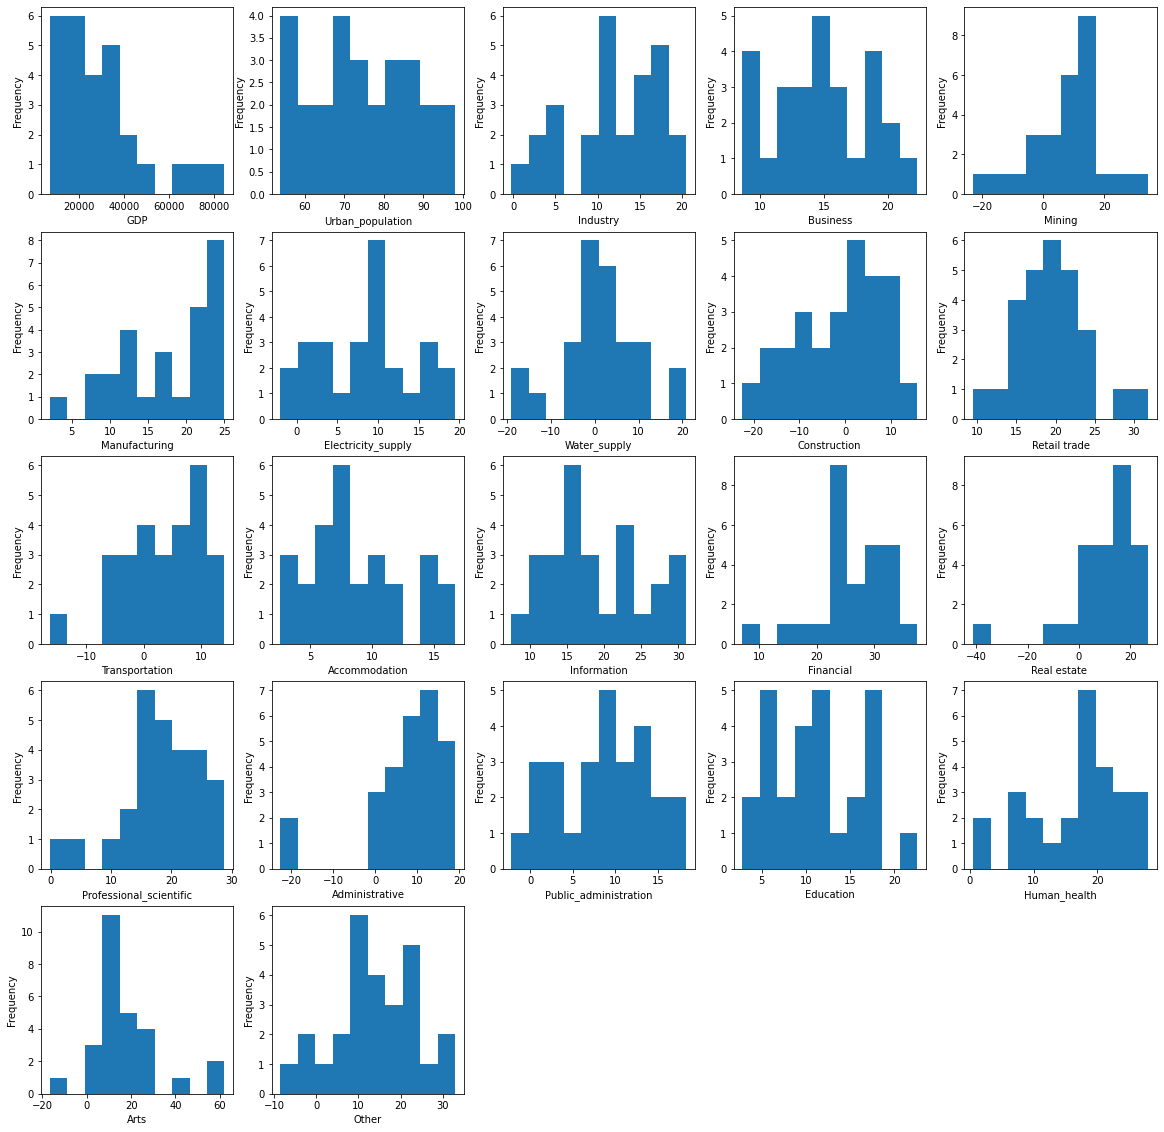

In [10]:
# Remove the year column
if 'Year' in pay_gap_2021.columns:
    pay_gap_2021 = pay_gap_2021.drop(['Year'], axis=1)
# Extract the number colunms
num_cols=[col for col in pay_gap_2021.columns if pay_gap_2021[col].dtype in ['int64','float64']]
num_cols_len=len(num_cols)
num_cols_per_row=5
print("There are",num_cols_len,"number columns in pay_gap_2021")
num_rows=int(num_cols_len/num_cols_per_row)+(num_cols_len % num_cols_per_row >0)
print(num_rows)
# Plot the frequencies of every number column
fig, axs=plt.subplots(num_rows,num_cols_per_row,figsize=(20,4*num_rows),gridspec_kw={'width_ratios':[1,1,1,1,1]})
for idx, col in enumerate(num_cols):
    row_idx=int(idx/num_cols_per_row)
    col_idx=idx % num_cols_per_row
    if idx>=num_cols_len:
        axs[row_idx,col_idx].axis('off')
    else:
        axs[row_idx,col_idx].hist(pay_gap_2021[col])
        axs[row_idx,col_idx].set_xlabel(col)
        axs[row_idx,col_idx].set_ylabel('Frequency')
# Remove any empty subplots
if num_cols_len % num_cols_per_row>0:
    for i in range(num_cols_len % num_cols_per_row, num_cols_per_row):
        fig.delaxes(axs[num_rows-1,i])
plt.tight_layout
plt.show()

We find extreme values in almost every number column, but we can group the outlier countries into different clusters in order to better understand them.

In [11]:
# Calculate coefficient of variation(CV)
cv=(pay_gap_2021[num_cols].std()/pay_gap_2021[num_cols].mean())*100
# Create DataFrame of the cv values
cv_df=pd.DataFrame({'CV':cv})
print(cv_df)

                                 CV
GDP                       64.905374
Urban_population          17.522873
Industry                  45.171102
Business                  25.705168
Mining                   151.881850
Manufacturing             36.594891
Electricity_supply        67.573354
Water_supply             612.421326
Construction            -974.813647
Retail trade              24.572919
Transportation           205.739054
Accommodation             45.850270
Information               33.435398
Financial                 26.056547
Real estate              125.230861
Professional_scientific   35.794942
Administrative           134.519214
Public_administration     64.437141
Education                 48.102910
Human_health              43.407248
Arts                      95.970242
Other                     72.785582


The data needs to be normalized, as there is a high degree of heterogeneity among features(CV>35%).

In [20]:
pay_gap_2021.to_csv('pay_gap_2021.csv', index=False)

## Principal Component Analysis

In [12]:
X= pay_gap_2021[num_cols]
# Normalize the features
X_norm=(X-X.mean(axis=0))/X.std(axis=0)
# Principal component analysis on number columns
pca=PCA()
# Fit and transform X_norm to PCA dataframe
X_pca=pca.fit_transform(X_norm)
# Convert to dataframe
names=[f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca_df=pd.DataFrame(X_pca,columns=names)
print(X_pca_df.head())
print("Shape of PCA DataFrame:",X_pca_df.shape)

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -2.584665 -1.692110 -0.384409  0.586485  1.061391 -1.182269  2.132974   
1  5.209759 -1.820833 -0.744330 -0.088776  0.272067  1.029793  0.260564   
2  0.038249  2.302154 -1.572696  0.190695 -0.818158  3.250748 -0.084059   
3 -0.011531  2.597254  1.461862 -1.286784  0.652203 -0.609136  1.307960   
4 -2.511675  2.438870  5.380843  0.723575  0.070936  1.828545  0.520392   

        PC8       PC9      PC10  ...      PC13      PC14      PC15      PC16  \
0  0.143808 -0.583056 -0.455484  ... -0.542875 -0.842590 -0.117323  0.140887   
1  2.236982  0.006903  0.651727  ...  1.008374 -0.330080  0.084035 -0.086998   
2 -0.988268  0.874566  0.034599  ... -0.483748 -0.893899 -0.333260 -0.200202   
3  0.689167  0.171394 -0.630258  ...  0.591439  0.038481 -0.273751  0.494912   
4  0.590620 -0.526295  0.718273  ...  0.148433  0.116746  0.128047  0.142787   

       PC17      PC18      PC19      PC20      PC21      PC22  
0  0

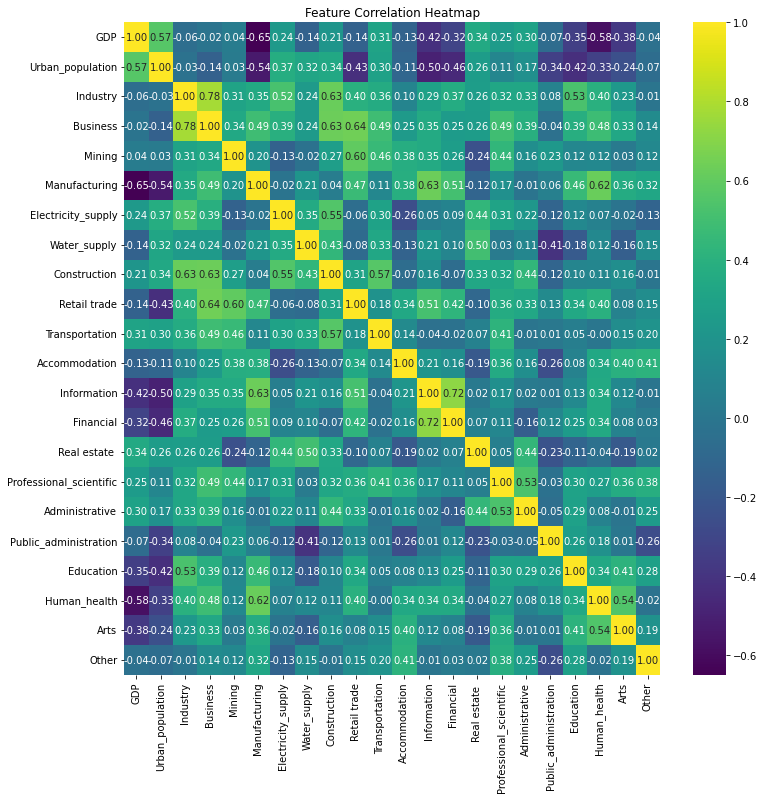

In [13]:
# Create covariance matrix
corr_matrix=np.corrcoef(X_norm.T)
# Create heatmap
plt.figure(figsize=(12,12))
sns.heatmap(corr_matrix,cmap='viridis',annot=True,fmt='.2f',xticklabels=pay_gap_2021[num_cols].columns,yticklabels=pay_gap_2021[num_cols].columns)
# Set plot title
plt.title('Feature Correlation Heatmap')
# Show the plot
plt.show()

There are some high correlations(0.72,0.78) so PCA will most likely be effective in dimensionality reduction.

In [14]:
# Calculate eigenvectors and eigenvalues
eigenvalues,eigenvectors=np.linalg.eig(corr_matrix)
print(eigenvalues)
print(eigenvectors)
# Sort the eigenvalues and eigenvectors in descending order
idx=eigenvalues.argsort()[::-1]
eigenvalues=eigenvalues[idx]
# Convert to dataframes
eigenvalues_df=pd.DataFrame({'Eigenvalue':eigenvalues},index=pay_gap_2021[num_cols].columns)
eigenvalues_df['Proportion']=eigenvalues_df['Eigenvalue']/eigenvalues_df['Eigenvalue'].sum()
eigenvalues_df['Cumulative Proportion']=eigenvalues_df['Proportion'].cumsum()

# Display dataframes
print("Eigenvalues:")
display(eigenvalues_df.style.format({'Eigenvalue':'{:.4f}','Proportion':'{:.4f}','Cumulative Proportion':'{:.4f}'}))

[5.67732093 4.02357597 2.20734859 1.81751108 1.63690384 1.38686761
 0.95590896 0.83616076 0.68497993 0.60546071 0.53364791 0.44766519
 0.31431433 0.24648809 0.01080261 0.0182781  0.02600764 0.03518566
 0.06537197 0.17853491 0.14135158 0.15031363]
[[-0.14450604 -0.34294137  0.2418915   0.18304709  0.1120137   0.16337818
   0.01938502  0.28435251 -0.10269667  0.28875727  0.01694564 -0.06960411
   0.0658758  -0.02988084  0.2672624  -0.32322511 -0.34850542 -0.2671692
   0.1722966  -0.0431474  -0.37945406 -0.02135048]
 [-0.15438987 -0.37544649  0.08160946 -0.10238043  0.03670073 -0.20672808
   0.13269378  0.02018119  0.21006727 -0.30229064 -0.28883689  0.02111315
   0.00613857  0.16395871 -0.31588683  0.25364394  0.01327459 -0.19114701
  -0.11575658  0.10997567 -0.32869368 -0.4186837 ]
 [ 0.30549434 -0.17252987 -0.14758968  0.18249059 -0.12945411 -0.04959861
  -0.02776729  0.03109086 -0.22219271 -0.09052101 -0.44405146  0.16910066
   0.01545337 -0.0324679  -0.34141359 -0.16485019 -0.2028718

,Eigenvalue,Proportion,Cumulative Proportion
GDP,5.6773,0.2581,0.2581
Urban_population,4.0236,0.1829,0.4409
Industry,2.2073,0.1003,0.5413
Business,1.8175,0.0826,0.6239
Mining,1.6369,0.0744,0.6983
Manufacturing,1.3869,0.0630,0.7613
Electricity_supply,0.9559,0.0435,0.8048
Water_supply,0.8362,0.0380,0.8428
Construction,0.6850,0.0311,0.8739
Retail trade,0.6055,0.0275,0.9015


Choose the number columns whose eigenvalues more than 1.(Principal components with eigenvalues greater than 1 are generally considered to be major features) The first six variables keep 76.13% of total variability which is a very good value.

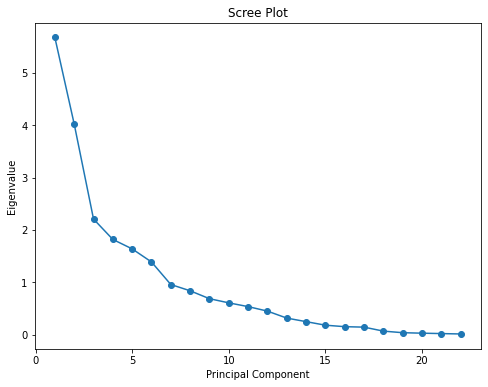

In [15]:
# Create a scree plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.show()

The primary purpose of the Scree plot is to help identify a point at which the eigenvalues of subsequent principal components start to decrease significantly after a certain point, often referred to as the "elbow point." The elbow point is an important reference because it signifies that continuing to retain more principal components beyond this point does not significantly enhance the explanatory power of the data. Therefore, it is common practice to select the number of principal components to retain up to the elbow point.

In this Scree plot, the eigenvalues of the first two principal components are significantly larger than those of the subsequent components, and the rate of decrease in eigenvalues becomes smaller after the second component. Hence, the second principal component can be considered the elbow point. However, it's worth noting that the first two components collectively explain only 44.09% of the variance.

[0.25806004 0.18288982 0.10033403 0.08261414 0.07440472 0.06303944
 0.04345041 0.03800731 0.03113545 0.02752094 0.02425672 0.02034842
 0.01428701 0.011204   0.00811522 0.00683244 0.00642507 0.00297145
 0.00159935 0.00118217 0.00083082 0.00049103]


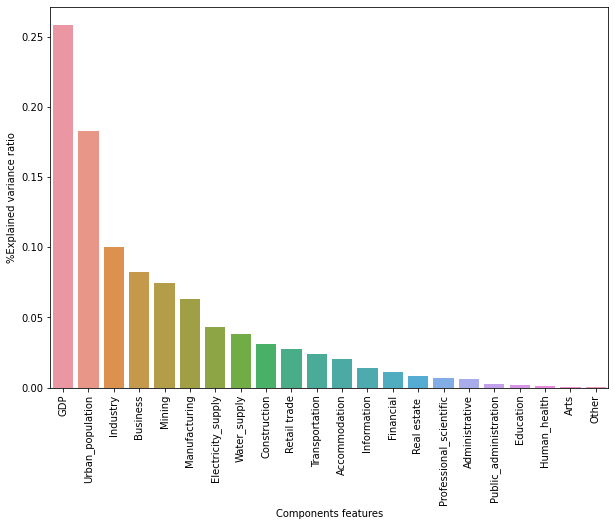

In [16]:
evr=pca.explained_variance_ratio_
print(evr)
features=pay_gap_2021[num_cols].columns

# Plot the EVR using matplotlib pyplot
plt.figure(figsize=(10,7))
sns.barplot(x=np.array(features),y=evr)
plt.xlabel("Components features")
plt.ylabel("%Explained variance ratio")
plt.xticks(rotation=90)
plt.show()

Visualize the Explained Variance Ratios (EVR) of individual principal components in Principal Component Analysis (PCA). This graphic is a bar chart where each bar represents a principal component, and the height of the bar represents the proportion of variance explained by that principal component. The EVR plot helps you understand the proportion of variance captured by each principal component in the data, typically used to determine how many principal components to retain to achieve dimensionality reduction goals. When you examine the EVR plot, you can focus on the point where eigenvalues start to drop rapidly, as these principal components often contain the most information.

[ 5.67732093  9.70089691 11.9082455  13.72575658 15.36266043 16.74952803
 17.70543699 18.54159775 19.22657768 19.8320384  20.36568631 20.81335149
 21.12766582 21.3741539  21.55268881 21.70300244 21.84435402 21.90972599
 21.94491165 21.97091929 21.98919739 22.        ]


<function matplotlib.pyplot.show(close=None, block=None)>

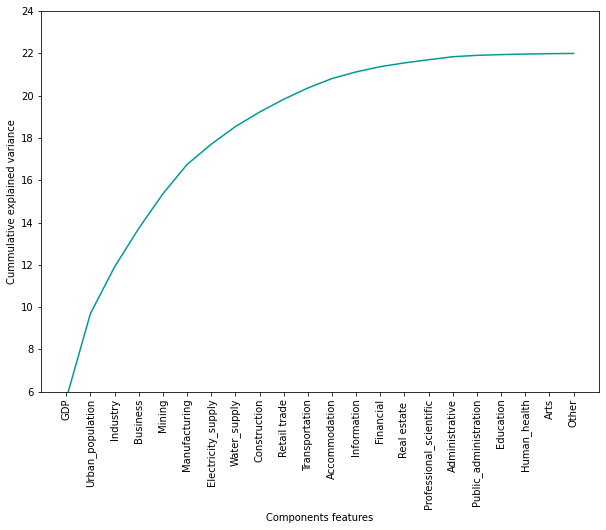

In [17]:
evc = np.cumsum(pca.explained_variance_)
print(evc)

features = pay_gap_2021[num_cols].columns

plt.figure(figsize=(10,7))
sns.lineplot(x=np.array(features), y=evc, color='#009999')
plt.xlabel("Components features")
plt.ylabel("Cummulative explained variance")
plt.ylim(6,24)
plt.xticks(rotation=90)
plt.show

Create a visualization to depict the change in Cumulative Explained Variance (CEV) as the number of principal components increases. This type of plot is often referred to as a PCA plot (Principal Component Analysis Plot) or Cumulative Explained Variance plot. The PCA plot illustrates how the cumulative explained variance gradually increases with an increasing number of principal components. Typically, you can focus on the point in the plot where the curve starts to level off, indicating that beyond that point, adding more principal components no longer significantly enhances the data's explanatory power. The choice of how many principal components to retain often depends on the task requirements and the goal of preserving a certain amount of data information.

In [18]:
loadings=pd.DataFrame(pca.components_.T[:,:6],index=np.array(features),columns=names[:6])
loadings

,PC1,PC2,PC3,PC4,PC5,PC6
GDP,0.144506,-0.342941,0.241891,0.183047,-0.112014,-0.163378
Urban_population,0.154390,-0.375446,0.081609,-0.102380,-0.036701,0.206728
Industry,-0.305494,-0.172530,-0.147590,0.182491,0.129454,0.049599
Business,-0.348191,-0.167212,-0.026280,0.058360,0.050195,0.025788
Mining,-0.211500,-0.028913,0.306721,0.204304,-0.415900,0.137660
Manufacturing,-0.313598,0.196520,-0.127273,-0.185583,-0.025311,0.041927
Electricity_supply,-0.099010,-0.321157,-0.269082,0.090689,0.175628,0.064328
Water_supply,-0.082693,-0.230865,-0.353531,-0.333296,-0.184644,0.120972
Construction,-0.195739,-0.349258,-0.070792,0.091050,0.014634,0.164091
Retail trade,-0.307751,0.050968,0.127976,0.177096,-0.243414,-0.195580


As most values are quite small and we cannot really see which variables determine which factors, we will further rotate the axis to visualize the relationship between variables and factors more clearly.

Axis Rotation: Varimax Orthogonal

In [19]:
features=pay_gap_2021[num_cols].columns
X= pay_gap_2021[features]
# Normalizing features
X_norm= (X-X.mean(axis=0))/X.std(axis=0)
# Fit factor analyzer with principal components and varimax rotation
fa=FactorAnalyzer(rotation="varimax",n_factors=6,method='principal')
fa.fit(X_norm)
# Get the rotated factor pattern
loadings2= pd.DataFrame(fa.loadings_,index=X_norm.columns,columns=[f"Factor{i+1}" for i in range(6)])
rotated_factor_pattern=loadings2[abs(loadings2)>=0.4].dropna(how='all')
# Display the results
rotated_factor_pattern

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6
GDP,-0.502641,NaN,NaN,NaN,-0.616858,NaN
Urban_population,-0.630608,NaN,NaN,NaN,NaN,NaN
Industry,NaN,0.699268,NaN,NaN,NaN,NaN
Business,NaN,0.583081,NaN,NaN,NaN,NaN
Mining,NaN,NaN,0.833200,NaN,NaN,NaN
Manufacturing,0.675007,NaN,NaN,NaN,0.568468,NaN
Electricity_supply,NaN,0.828761,NaN,NaN,NaN,NaN
Water_supply,NaN,0.578545,NaN,0.624657,NaN,NaN
Construction,NaN,0.779916,NaN,NaN,NaN,NaN
Retail trade,0.627668,NaN,0.433814,NaN,NaN,0.409284


Factor 1 is determined by GDP per capita, Urban population(%), Manufacturing, Retail trade, Information and Financial pay gaps (Urban & Service Pay Gap) Factor 2 is determined by pay gaps in Industry, Business, Electricity Supply, Construction, and Real Estate (Industry & Business Pay Gap) Factor 3 is determined by pay gaps in Mining and Accommodation (Resource Extraction Pay Gap) Factor 4 is determined by pay gaps Water Supply, Public Administration and other (Public Service Pay Gap) Factor 5 is determined by GDP per capita(euros) and pay gaps in Education, Human Health and Arts (Economic Development Pay Gap) Factor 6 is determined by pay gaps in Scientific Administrative areas (Science & Administration Pay Gap)

# Clustering

In [21]:
from pyspark.sql import SparkSession

# Create Spark session
spark = SparkSession.builder.appName("Clustering").getOrCreate()

# Create Spark session
df = spark.read.csv("pay_gap_2021.csv", header=True, inferSchema=True)


In [22]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

# Create feature vectors
feature_cols = df.columns[1:]# Suppose the first column is the identification column and the following columns are the features
vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = vector_assembler.transform(df)

# Standardized features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)


23/10/08 05:48:36 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [23]:
from pyspark.ml.clustering import KMeans

# Train the K-Means model
kmeans = KMeans(k=8, seed=1, featuresCol="scaled_features", predictionCol="cluster")
model = kmeans.fit(df)


In [24]:
# Predictive clustering
predictions = model.transform(df)

# View clustering results
predictions.select("Country", "cluster").show()

# Evaluation of clustering results if needed


+--------------+-------+
|       Country|cluster|
+--------------+-------+
|       Austria|      0|
|       Belgium|      7|
|      Bulgaria|      5|
|       Croatia|      3|
|        Cyprus|      1|
|Czech Republic|      0|
|       Denmark|      7|
|       Estonia|      0|
|       Finland|      0|
|        France|      5|
|       Germany|      0|
|       Hungary|      6|
|         Italy|      5|
|        Latvia|      6|
|     Lithuania|      6|
|    Luxembourg|      7|
|         Malta|      0|
|   Netherlands|      0|
|        Norway|      0|
|        Poland|      5|
+--------------+-------+
only showing top 20 rows



In [25]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession



# Initialize the BisectingKMeans model
kmeans = BisectingKMeans().setK(8) # Sets the number of clusters

# Training model
model = kmeans.fit(df)

# Predict which cluster each sample belongs to
predictions = model.transform(df)

# Print results
predictions.select("features", "prediction").show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[36950.0,59.0,18....|         4|
|[35950.0,98.12,5....|         4|
|[6950.0,76.03,12....|         0|
|[13500.0,57.88,11...|         0|
|[25480.0,66.86,9....|         3|
|[18020.0,74.21,15...|         1|
|[50010.0,88.24,14...|         5|
|[16490.0,69.42,20...|         1|
|[37250.0,85.6,16....|         4|
|[32530.0,81.24,15...|         3|
|[35480.0,77.54,17...|         4|
|[13690.0,72.25,17...|         0|
|[26780.0,71.35,5....|         3|
|[12970.0,68.42,14...|         0|
|[14820.0,68.25,12...|         1|
|[84490.0,91.67,-0...|         7|
|[22760.0,94.81,10...|         2|
|[41860.0,92.57,13...|         5|
|[71150.0,83.32,14...|         6|
|[13760.0,60.08,4....|         0|
+--------------------+----------+
only showing top 20 rows

